In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as tt
import torchvision.transforms.functional as ttF


import pathlib
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
torch.manual_seed(0)

In [3]:
LABELS = ['wP', 'wN', 'wB', 'wR', 'wQ', 'wK', 'bP', 'bN', 'bB', 'bR', 'bQ', 'bK', 'xx']

In [4]:
identity = lambda x: x

augument = tt.Compose([
    tt.RandomChoice([identity, tt.GaussianBlur(3), tt.GaussianBlur(5)]),
    tt.RandomAffine(5, (0.2, 0.2), (0.8, 1.2), [-5, 5]),
    tt.Lambda(lambda x: ttF.adjust_brightness(x, float(torch.empty(1).uniform_(0.5, 1.2)))),
])

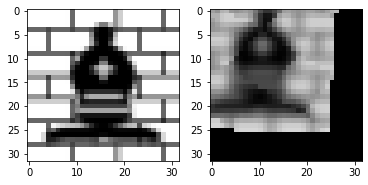

In [5]:
# Example of augumented data

filename = 'data/train/bB--cburnett-ex000.png'
before = PIL.Image.open(filename)
after = ttF.to_pil_image(augument(ttF.to_tensor(before.convert('L')))).convert('RGB')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(before)
axes[1].imshow(after)

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dirname):
        super(torch.utils.data.Dataset, self).__init__()
        self.files = sorted(pathlib.Path(dirname).glob('*.png'))
    
    def __getitem__(self, i):
        file = self.files[i]
        image = PIL.Image.open(file)
        assert image.mode == 'RGB'
        image = image.convert('L')
        x = ttF.to_tensor(image)
        label = file.name.split('--')[0]
        y = torch.LongTensor([LABELS.index(label)])
        return x, y
    
    def __len__(self):
        return len(self.files)

In [7]:
dataset = Dataset('data/train')

len_total = len(dataset)
len_test = int(0.05 * len_total)
len_train = len_total - len_test

trainset, testset = torch.utils.data.random_split(dataset, [len_train, len_test])
len(trainset), len(testset)

(4465, 234)

In [8]:
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

In [9]:
# Define model

import torch
import torch.nn as nn
import torch.nn.functional as F

in_h = in_w = 32
out_size = 13

def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.ReLU(),        
        nn.Flatten(),
        nn.Linear(4 * in_h * in_w, 256),
        nn.Dropout(0.3),
        nn.Linear(256, 256),
        nn.Dropout(0.3),        
        nn.ReLU(),
        nn.Linear(256, out_size),
    )

make_model()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=256, bias=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): Dropout(p=0.3, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=13, bias=True)
)

In [10]:
def to_loss(y, yt):
    return F.cross_entropy(y, yt)

def to_prediction(y):
    return y.argmax(dim=-1)

def to_probability(y):
    return torch.max(F.softmax(y, dim=-1), dim=-1).values

In [11]:
class Metric:
    def __init__(self):
        self.cnt = torch.zeros(1)
        self.cnt_correct = torch.zeros(1)
        self.loss = torch.zeros(1)

    def update(self, y, yt, loss):
        cnt = yt.numel()
        self.cnt += cnt
        self.cnt_correct += torch.sum(to_prediction(y) == yt)
        self.loss += cnt * loss
        return self.compute()

    def compute(self):
        accuracy = self.cnt_correct / self.cnt
        loss = self.loss / self.cnt
        return accuracy, loss

In [12]:
def train(model, num_epochs):
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        metric = Metric()
        model.train()
        with tqdm(trainloader) as it:
            for x, yt in it:
                optimizer.zero_grad()
                x = augument(x)
                y = model(x)
                yt = yt.reshape(-1)
                yl = to_loss(y, yt)
                yl.backward()
                optimizer.step()
                acc, loss = metric.update(y.detach(), yt.detach(), yl.detach())
                it.set_postfix(acc=float(acc), loss=float(loss))

        metric = Metric()
        model.eval()
        with tqdm(testloader) as it:
            for x, yt in it:
                y = model(x)
                yt = yt.reshape(-1)
                yl = to_loss(y, yt)
                acc, loss = metric.update(y.detach(), yt.detach(), yl.detach())
                it.set_postfix(acc=float(acc), loss=float(loss))

In [13]:
model = make_model()
train(model, num_epochs=128)

100%|██████████| 280/280 [00:08<00:00, 34.48it/s, acc=0.94, loss=0.192] 


100%|██████████| 15/15 [00:00<00:00, 64.79it/s, acc=0.991, loss=0.0228]


100%|██████████| 15/15 [00:00<00:00, 76.58it/s, acc=0.987, loss=0.038]


In [14]:
#
# Save model
#

from datetime import datetime

timestamp = datetime.strftime(datetime.now(), "%F-%H-%M-%S")
filename = f"data/checkpoint/model-{timestamp}.pt"
print(filename)
torch.save({'model_state_dict': model.state_dict()}, filename)

data/checkpoint/model-2021-04-22-17-35-08.pt


In [40]:
#
# Load model
#
checkpoint_file = 'data/checkpoint/model-2021-04-22-17-35-08.pt'
checkpoint = torch.load(checkpoint_file)

model = make_model()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
None

In [16]:
def predict(model, x):
    x = x.unsqueeze(0)
    y = model(x)[0]
    z = to_prediction(y)
    w = to_probability(y)
    return z, w

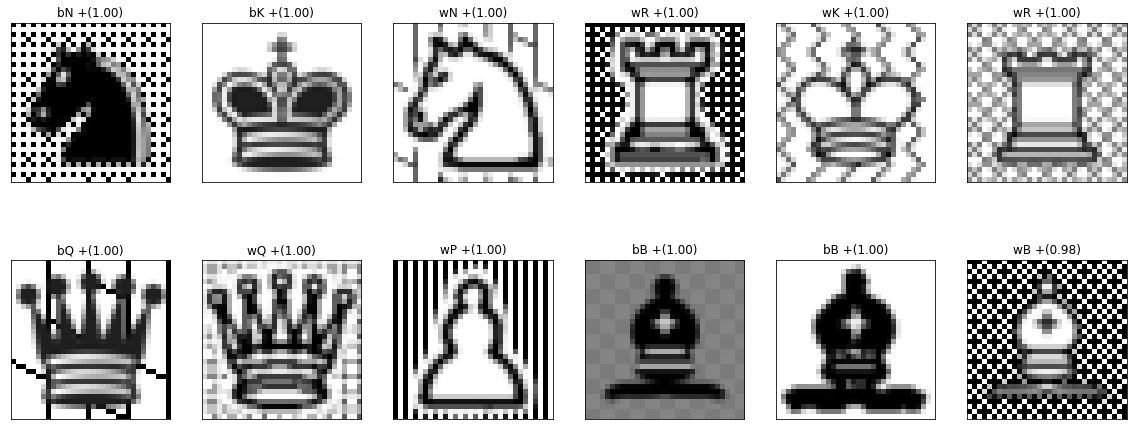

In [183]:
#
# Plot test dataset result
#
h, w = 2, 6
n = h * w
offset = 8 * n
fig, axes = plt.subplots(h, w, figsize=(20, 8))

model.eval()
for i in range(h):
    for j in range(w):
        x, y = testset[offset + i * w + j]
        prediction, probability = predict(model, x)
        correct = prediction == y[0]
        title = LABELS[prediction] + ' ' + ('+' if correct else '-') + f"({float(probability):.2f})"
        ax = axes[i][j]
        ax.set_title(title, color='black' if correct else 'red')
        ax.set(title=title, xticks=[], yticks=[])
        ax.imshow(ttF.to_pil_image(x).convert('RGB'))

In [114]:
#
# Predict pieces on 8x8 board
#

def predict8x8(model, image):
    image = image.convert('L').resize([256, 256])
    x = ttF.to_tensor(image)
    x = x.reshape([1, 8, 32, 8, 32]).permute([0, 1, 3, 2, 4]).reshape([64, 1, 32, 32])
    y = model(x)
    z, w = torch.max(torch.softmax(y, dim=-1), dim=-1)
    z = z.reshape([8, 8]).detach()
    w = w.reshape([8, 8]).detach()
    return z, w

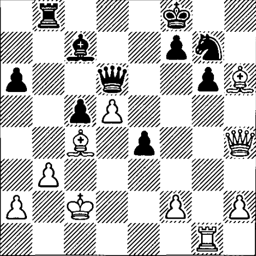

In [128]:
image = PIL.Image.open('data/example/ex000.png').convert('L').resize([256, 256])
image

In [129]:
predict8x8(model, image)

(tensor([[0.9207, 1.0000, 0.9926, 0.6423, 0.9782, 1.0000, 0.9924, 0.7896],
         [0.6589, 0.9950, 0.9980, 0.9853, 0.6896, 1.0000, 1.0000, 0.9828],
         [1.0000, 0.6669, 0.9894, 1.0000, 0.9889, 0.6424, 1.0000, 0.7207],
         [0.6855, 0.9933, 1.0000, 1.0000, 0.6255, 0.9931, 0.7452, 0.9902],
         [0.9653, 0.7000, 0.9998, 0.6817, 1.0000, 0.6858, 0.9945, 1.0000],
         [0.6272, 0.9930, 0.7083, 0.9925, 0.6680, 0.9943, 0.7963, 0.9953],
         [1.0000, 0.6789, 1.0000, 0.7386, 0.9953, 1.0000, 0.9963, 1.0000],
         [0.8985, 0.9896, 0.8940, 0.9990, 0.8949, 0.9946, 1.0000, 0.9993]]),
 tensor([[12,  9, 12, 12, 12, 11, 12, 12],
         [12, 12,  8, 12, 12,  6,  7, 12],
         [ 6, 12, 12, 10, 12, 12,  6,  2],
         [12, 12,  6,  0, 12, 12, 12, 12],
         [12, 12,  2, 12,  6, 12, 12,  4],
         [12,  0, 12, 12, 12, 12, 12, 12],
         [ 0, 12,  5, 12, 12,  0, 12,  0],
         [12, 12, 12, 12, 12, 12,  3, 12]]))

In [130]:
#
# Convert to FEN
#

FEN_PIECE_CHARS = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

def to_fen(result):
    fen = ''
    cnt = 0
    for i in range(8):
        if i > 0:
            fen += '/'
        cnt = 0
        for j in range(8):
            piece = result[i][j]
            if piece == 12:
                cnt += 1
            else:
                if cnt > 0:
                    fen += str(cnt)
                fen += FEN_PIECE_CHARS[piece]
                cnt = 0
        if cnt > 0:
            fen += str(cnt)            
    return fen


def predict_fen(model, filename):
    probability, labels = predict8x8(model, PIL.Image.open(filename))
    return to_fen(labels)

1r3k2/2b2pn1/p2q2pB/2pP4/2B1p2Q/1P6/P1K2P1P/6R1


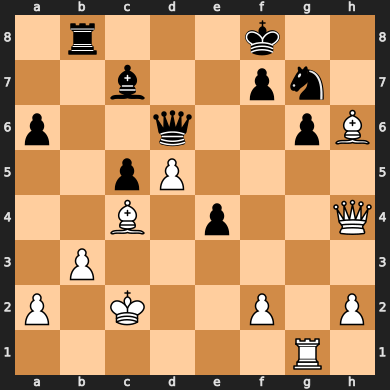

In [131]:
import chess

fen = predict_fen(model, 'data/example/ex000.png')
print(fen)

chess.Board(fen)